#Game

In [756]:
import pygame
import numpy as np
from queue import PriorityQueue
import matplotlib.pyplot as plt
import math
import random

In [757]:
# Constants
SCREEN_SIZE = (600, 600)
CELL_SIZE = 50
GRID_OFFSET_X = 50
GRID_OFFSET_Y = 50
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)
YELLOW = (255, 255, 0)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
DIRECTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

In [758]:
class Robot:
    def __init__(self, name, position, skill, backpack_capacity, id):
        self.name = name
        self.position = position
        self.id = id
        self.skill = skill
        self.backpack_capacity = backpack_capacity
        self.backpack_contents = []

    def unload_backpack(self, environment):
        if self.position == environment.collection_point:
            environment.deposited_treasures.extend(self.backpack_contents)
            self.backpack_contents = []
            print(f"{self.name} unloaded backpack at collection point.")
        else:
            print(f"{self.name} cannot unload backpack. Not at collection point.")

    def has_tasks_assigned(self):
        return bool(self.backpack_contents)

In [759]:
class GoldCoinRobot(Robot):
    def __init__(self, name, position, backpack_capacity, id):
        super().__init__(name, position, skill="or", backpack_capacity=backpack_capacity, id=id)


class GemRobot(Robot):
    def __init__(self, name, position, backpack_capacity, id):
        super().__init__(name, position, skill="pierres", backpack_capacity=backpack_capacity, id=id)


class ChestOpenerRobot(Robot):
    def __init__(self, name, position, backpack_capacity, id):
        super().__init__(name, position, skill="ouvr", backpack_capacity=backpack_capacity, id=id)

In [760]:
class Treasure:
    def __init__(self, value, position, treasure_type):
        self.value = value
        self.position = position
        self.treasure_type = treasure_type
        self.unlocked = False
        self.deposited = False

    def __str__(self):
        return f"{self.treasure_type} at position {self.position}"

In [761]:
class Environment:
    def __init__(self, size):
        self.size = size
        self.grid = [[None for _ in range(size)] for _ in range(size)]
        self.treasures = []
        self.collection_point = (0, size // 2)
        self.deposited_treasures = []

    def add_robot(self, robot):
        x, y = robot.position
        if self.grid[x][y] is None:
            self.grid[x][y] = robot
            return True
        else:
            print("Position already occupied.Cannot place robot. ")
            return False

    def add_treasure(self, treasure):
        x, y = treasure.position
        if self.grid[x][y] is None:
            self.grid[x][y] = treasure
            self.treasures.append(treasure)
            return True
        else:
            print("Position already occupied. Cannot place treasure.")
            return False

    def move_robot(self, robot, new_position):
        old_x, old_y = robot.position
        new_x, new_y = new_position
        if self.is_valid_position(new_x, new_y) and self.grid[new_x][new_y] is None:
            self.grid[old_x][old_y] = None
            self.grid[new_x][new_y] = robot
            robot.position = new_position
            return True
        else:
            print("Invalid move. Cannot move to specified position.")
            return False

    def unlock_treasure(self, robot, treasure):
        if robot.skill == treasure.treasure_type:
            treasure.unlocked = True
            print(f"{robot.name} unlocked the treasure chest at position {treasure.position}.")
            return True
        else:
            print(f"{robot.name} does not have the required skill to unlock this treasure chest.")
            return False

    def deposit_treasure(self, robot, treasure):
        if treasure in self.treasures and treasure.unlocked and not treasure.deposited:
            if isinstance(robot, ChestOpenerRobot) or robot.skill == treasure.treasure_type:
                if len(robot.backpack_contents) < robot.backpack_capacity:
                    treasure.deposited = True
                    robot.backpack_contents.append(treasure)
                    print(f"{robot.name} collected {treasure.value} units of treasure.")
                    return True
                else:
                    print(f"{robot.name}'s backpack is full. Cannot collect more treasure.")
                    return False
            else:
                print(f"{robot.name} cannot deposit treasure. Skill mismatch.")
                return False
        return False

    def is_valid_position(self, x, y):
        return 0 <= x < self.size and 0 <= y < self.size

    def display_environment(self):
        grid_data = np.zeros((self.size, self.size, 3), dtype=int)
        for i in range(self.size):
            for j in range(self.size):
                if isinstance(self.grid[i][j], Robot):
                    grid_data[i][j] = [0, 255, 0]  # Green color for robots
                elif isinstance(self.grid[i][j], Treasure):
                    if self.grid[i][j].treasure_type == "pierres":
                        grid_data[i][j] = [255, 0, 0]  # Red color for gems
                    elif self.grid[i][j].treasure_type == "or":
                        grid_data[i][j] = [255, 255, 0]  # Yellow color for gold coins
                    elif self.grid[i][j].treasure_type == "ouvr":
                        grid_data[i][j] = [0, 0, 255]  # Blue color for chest treasures
                elif (i, j) == self.collection_point:
                    grid_data[i][j] = [0, 0, 255]  # Blue color for collection point

        plt.imshow(grid_data)
        plt.title("Environment Grid")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.xticks(range(self.size))
        plt.yticks(range(self.size))
        plt.grid(color='lightgray', linestyle='-', linewidth=0.5)  # Light gray grid lines
        plt.show()

In [762]:
# Function to find the nearest robot
def find_nearest_robot(env, target_position, robots):
    distances = [manhattan_distance(robot.position, target_position) for robot in robots]
    closest_robot_index = distances.index(min(distances))
    return robots[closest_robot_index]


# Calculate Manhattan distance between two points
def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])


In [763]:
# A* pathfinding algorithm
def astar_search(env, start, goal):
    def heuristic(node):
        return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

    def reconstruct_path(came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        return path[::-1]
    
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {start: 0}

    while not frontier.empty():
        current = frontier.get()

        if current == goal:
            return reconstruct_path(came_from, goal)

        for dx, dy in DIRECTIONS:
            next_node = (current[0] + dx, current[1] + dy)
            new_cost = cost_so_far[current] + 1

            if (
                env.is_valid_position(*next_node)
                and env.grid[next_node[0]][next_node[1]] is None
                and next_node not in [treasure.position for treasure in env.treasures]
            ):
                
                if next_node not in cost_so_far or new_cost < cost_so_far[next_node]:
                    cost_so_far[next_node] = new_cost
                    priority = new_cost + heuristic(next_node)
                    frontier.put(next_node, priority)
                    came_from[next_node] = current

    return None


In [764]:
# Function to simulate the opening of a chest treasure
def open_treasure(robot, treasure):
    treasure.unlocked = True
    print(f"{robot.name} {robot.id} opened the treasure chest at position {treasure.position}.")


def distribute_tasks(env, robots):
    assigned_tasks = []
    for treasure in env.treasures:
        # if treasure.treasure_type == "ouvr":
            opener_robots = [robot for robot in robots if isinstance(robot, ChestOpenerRobot)]
            if opener_robots:
                assigned_robot = find_nearest_robot(env, treasure.position, opener_robots)
                if assigned_robot:
                    assigned_robot.backpack_contents.append(treasure)
                    assigned_tasks.append([assigned_robot, treasure])
                    print(f"{assigned_robot.name} {assigned_robot.id} assigned to open the chest at position {treasure.position}.")
                else:
                    print(f"No suitable ChestOpenerRobot found to open the chest at position {treasure.position}.")
            else:
                print("No ChestOpenerRobot available to open the chest.")
    print()
    
    
    if len(assigned_tasks) > 0:
        for i in assigned_tasks:
            # path = astar_search(env, i[0].position, i[1].position)
            # if path:
            #     for position in path[1:]:
            #         env.move_robot(i[0], position)
            #         pygame.time.wait(500)
                
                open_treasure(i[0], i[1])
    else:
        print("No robot assigned to open a chest.")
    
    print()
    
    for treasure in env.treasures:
        if not treasure.treasure_type == "ouvr":
            # nearest_robot = find_nearest_robot(env, treasure.position, robots)
            nearest_robot = find_nearest_robot_with_skill(env, treasure.position, treasure.treasure_type, robots)
            if nearest_robot:
                nearest_robot.backpack_contents.append(treasure)
                print(f"{nearest_robot.name} {nearest_robot.id} assigned to collect {treasure.treasure_type} at position {treasure.position}.")
            else:
                print(f"No suitable robot found to collect {treasure.treasure_type} at position {treasure.position}.")

                # Add a placeholder "waiting" treasure if collection point is free
                if env.grid[env.collection_point[0]][env.collection_point[1]] is None:
                    env.add_treasure(Treasure(0, env.collection_point, "waiting"))
                else:
                    print("Position already occupied. Cannot place treasure.")

    # Ensure that every robot has a task assigned
    for robot in robots:
        if not robot.has_tasks_assigned():
            print(f"No task assigned for {robot.name} {robot.id}. Waiting for a suitable task.")
            if env.grid[env.collection_point[0]][env.collection_point[1]] is None:
                env.add_treasure(Treasure(0, env.collection_point, "waiting"))
            else:
                print("Position already occupied. Cannot place treasure.")



# Function to find the nearest robot with a specific skill
def find_nearest_robot_with_skill(env, target_position, skill, robots):
    skill_robots = [robot for robot in robots if isinstance(robot, (GoldCoinRobot, GemRobot, ChestOpenerRobot)) and robot.skill == skill]
    if skill_robots:
        distances = [manhattan_distance(robot.position, target_position) for robot in skill_robots]
        closest_robot_index = distances.index(min(distances))
        return skill_robots[closest_robot_index]
    else:
        return None

In [765]:

def create_environment(env_config):
    size = int(env_config[0].split()[0])
    env = Environment(size)

    # Add treasures and robots
    for item in env_config[2:]:
        if item.startswith("tres:"):
            _, treasure_type, pos_x, pos_y, value = item.split(":")
            treasure = Treasure(int(value), (int(pos_x), int(pos_y)), treasure_type)
            env.add_treasure(treasure)
        elif item.startswith("AG:"):
            _, skill, pos_x, pos_y, capacity = item.split(":")
            robot = None
            if skill == "ouvr":
                robot = ChestOpenerRobot(f"Robot_{skill}", (int(pos_x), int(pos_y)), int(capacity), env_config.index(item))
            elif skill == "pierres":
                robot = GemRobot(f"Robot_{skill}", (int(pos_x), int(pos_y)), int(capacity), env_config.index(item))
            elif skill == "or":
                robot = GoldCoinRobot(f"Robot_{skill}", (int(pos_x), int(pos_y)), int(capacity), env_config.index(item))
            env.add_robot(robot)

    return env

In [766]:
# Algorithm to plan actions for each robot
def plan_actions(env, robot):
    for i in robot.backpack_contents:
        task = i
        path = astar_search(env, robot.position, task.position)
        if path:
            for position in path[1:]:
                env.move_robot(robot, position)
                pygame.time.wait(500)  # Adjust speed of movement
        env.deposit_treasure(robot, task)


Robot_ouvr 13 assigned to open the chest at position (2, 10).
Robot_ouvr 12 assigned to open the chest at position (3, 1).
Robot_ouvr 13 assigned to open the chest at position (4, 8).
Robot_ouvr 13 assigned to open the chest at position (4, 11).
Robot_ouvr 12 assigned to open the chest at position (6, 3).
Robot_ouvr 12 assigned to open the chest at position (7, 0).
Robot_ouvr 13 assigned to open the chest at position (7, 9).
Robot_ouvr 12 assigned to open the chest at position (10, 2).
Robot_ouvr 13 assigned to open the chest at position (10, 7).
Robot_ouvr 13 assigned to open the chest at position (11, 10).

Robot_ouvr 13 opened the treasure chest at position (2, 10).
Robot_ouvr 12 opened the treasure chest at position (3, 1).
Robot_ouvr 13 opened the treasure chest at position (4, 8).
Robot_ouvr 13 opened the treasure chest at position (4, 11).
Robot_ouvr 12 opened the treasure chest at position (6, 3).
Robot_ouvr 12 opened the treasure chest at position (7, 0).
Robot_ouvr 13 opened 

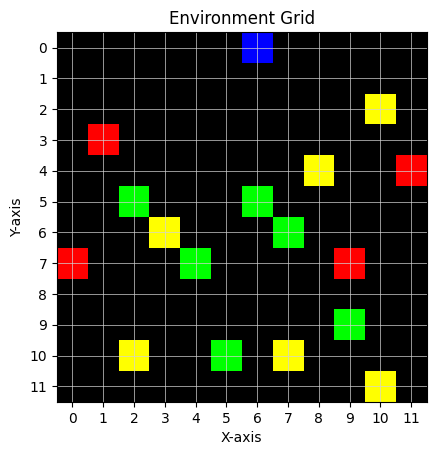

In [767]:
def main():
    # Environment configuration
    env_config = [
        "12 12",
        "5 0",
        "tres:or:2:10:2",
        "tres:pierres:3:1:3",
        "tres:or:4:8:2",
        "tres:pierres:4:11:6",
        "tres:or:6:3:6",
        "tres:pierres:7:0:2",
        "tres:pierres:7:9:3",
        "tres:or:10:2:8",
        "tres:or:10:7:8",
        "tres:or:11:10:2",
        "AG:ouvr:7:4:10",
        "AG:ouvr:9:9:10",
        "AG:pierres:5:2:9",
        "AG:pierres:5:6:15",
        "AG:or:6:7:6",
        "AG:or:10:5:17"
    ]

    env = create_environment(env_config)
    robots = [robot for row in env.grid for robot in row if isinstance(robot, Robot)]

    # Distribute tasks to robots
    distribute_tasks(env, robots)

    print()
    
    for robot in robots:
        plan_actions(env, robot)
    
    print()
    
    # Display environment
    env.display_environment()


if __name__ == "__main__":
    main()